In [7]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [2]:
config = configparser.ConfigParser()
config.read('db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)

In [3]:
def get_data(query, columns = None):
    """Query in SQL STRING
    Columns = List of strings representing the columns for the df"""
    mycursor = sql_conn.cursor()
    mycursor.execute(query)
    result = mycursor.fetchall()
    data_list = list(result)
    if columns == None:
        df = pd.DataFrame(data_list)
        return df
    else:
        df = pd.DataFrame(data_list, columns= columns)
        return df

In [6]:
#Find all events where ALS was diagnosed (has to appear 2+ times)

query_diagnosis_columns = """SELECT *
FROM syscolumns
WHERE id=OBJECT_ID('CDW_NEW.deid_uf.DiagnosisEventFact') """
diagnosis_columns = get_data(query_diagnosis_columns)[0].to_list()
query_als = """
    SELECT * 
    FROM CDW_NEW.deid_uf.DiagnosisEventFact
    WHERE DiagnosisName LIKE '%amyotrophic lateral sclerosis%'
"""
als_diagnosis = get_data(query_als, diagnosis_columns)

#Screen for recurrence of minimum 2

als_diagnosis = als_diagnosis.groupby('PatientDurableKey').filter(lambda x: len(x) >= 2)
unique_pats = als_diagnosis['PatientDurableKey'].nunique()
print(f"# unique: {unique_pats}")

als_diagnosis

# unique: 3098


,DeidLds,PatientDurableKey,DiagnosisEventKey,DiagnosisKey,DiagnosisName,PatientKey,AgeKey,AgeKeyValue,EncounterKey,DepartmentKey,...,DocumentedByProviderType,DocumentedByProviderPrimarySpecialty,DocumentedByProviderDurableKey,Type,Status,PresentOnAdmission,HospitalDiagnosis,EmergencyDepartmentDiagnosis,Chronic,Count
0,deid_uf,D581652828FB6A,D359696B2760E3,78060,Amyotrophic lateral sclerosis (CMS code),DF02D82E4E380E,30052004.0,NaN,D1D3C49CB3BBC1,1329,...,Physician,Lab Medicine,197886,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
1,deid_uf,D765F6E841EA5B,D48C7A8BA6B279,78060,Amyotrophic lateral sclerosis (CMS code),DB88206D4EA5DF,21285004.0,NaN,D5765A7BDA6F1A,1329,...,Physician,Lab Medicine,197886,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
2,deid_uf,DB7F7A679AEC20,D1043AFD7D0863,78060,Amyotrophic lateral sclerosis (CMS code),D873D1C4252641,24030004.0,NaN,D4EF6174EE5110,1329,...,Physician,Lab Medicine,197886,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
3,deid_uf,D626EFBA9EC82B,D45336AC4FAC9A,931514,Amyotrophic lateral sclerosis (CMS code),D7A38604990135,23039004.0,NaN,DF0720BB022B33,1329,...,Physician,Lab Medicine,197886,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
4,deid_uf,D59F519CA2A0A2,DBF9E672B4DB1B,931514,Amyotrophic lateral sclerosis (CMS code),D70CC9028623EA,17886004.0,NaN,D1CCEC1BA6874E,1329,...,Physician,Lab Medicine,197886,Billing Diagnosis,Active,*Not Applicable,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71460,deid_uf,DEE639317F70A8,D6510E95A60D4D,875590,Amyotrophic lateral sclerosis (ALS) (CMS code),DF70455FD4C74B,NaN,NaN,D52D83C992CAF2,2518,...,Physician,Geriatric Medicine,238976,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
71462,deid_uf,D9CA75D5986B56,D2C798044FF108,875590,Amyotrophic lateral sclerosis (ALS) (CMS code),DDA2181B775EC7,NaN,NaN,DAA5640637308A,2902,...,*Unknown,*Unknown,1035334,Encounter Diagnosis,Active,*Not Applicable,NaN,0.0,0.0,1
71463,deid_uf,DEBFFB018FFDA2,D260601B716993,75967,ALS (amyotrophic lateral sclerosis) (CMS code),DDEC96C852738D,-1.0,NaN,D7B92B2D544734,73,...,Physician,Anesthesiology,518836,Medical History,Active,*Not Applicable,NaN,NaN,NaN,1
71464,deid_uf,D9328D040FD1AA,DF8E62A24C1B3F,875590,Amyotrophic lateral sclerosis (ALS) (CMS code),DEF4D397F78733,29152004.0,NaN,D6281639F3456F,2623,...,Physician,Internal Medicine,754479,Problem List,Active,*Unspecified,1.0,NaN,0.0,1


# Sex Breakdown

In [8]:
query_patinfo_columns = """SELECT *
FROM syscolumns
WHERE id=OBJECT_ID('CDW_NEW.deid_uf.PatDurableDim') """
patinfo_columns = get_data(query_patinfo_columns)[0].to_list()

# Create sex distribution chart
def sex_dist(sex_table, title):
    unique_key = sex_table.groupby('PatientDurableKey').first().reset_index()
    sex_counts = unique_key["Sex"].value_counts()
    sex_counts.plot(kind = 'bar')
    plt.title(title)
    plt.xlabel("Gender")
    plt.ylabel("Count")
    plt.show()
    print(sex_counts)

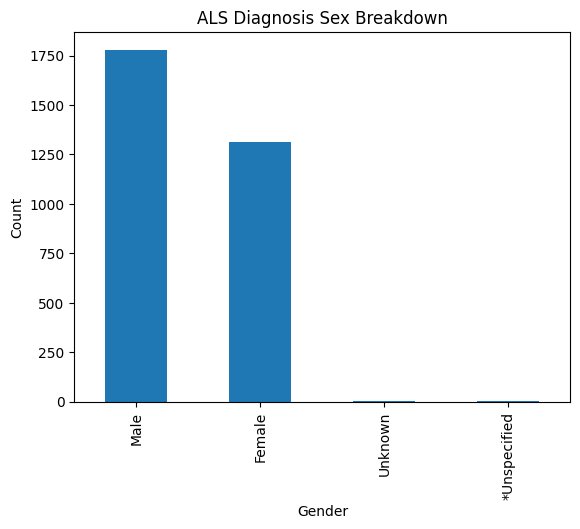

Sex
Male            1780
Female          1312
Unknown            5
*Unspecified       1
Name: count, dtype: int64


In [9]:
#Convert the relevant patient IDs to string— ALS
als_keys_list = tuple(als_diagnosis['PatientDurableKey'].unique())

#Grab relevant PatientDurableKeys

query_als_patinfo = f"""
    SELECT * 
    FROM CDW_NEW.deid_uf.PatDurableDim
    WHERE PatientDurableKey IN {als_keys_list}
"""
als_patinfo = get_data(query_als_patinfo, patinfo_columns)

#Merge the tables together
als_composite = pd.merge(als_diagnosis, als_patinfo, on="PatientDurableKey")

sex_dist(als_composite[["PatientDurableKey", "Sex"]], "ALS Diagnosis Sex Breakdown")